In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load the dataset
data = pd.read_csv('data/Duke Roster and Performance Data.csv')

print(data)

print(data.dtypes)

    Year School      Coach  numGames  numWins  numLosses  overallPct  \
0   2023   Duke       Elko        13        8          5    0.615385   
1   2022   Duke       Elko        13        9          4    0.692308   
2   2021   Duke  Cutcliffe        12        3          9    0.250000   
3   2020   Duke  Cutcliffe        11        2          9    0.181818   
4   2019   Duke  Cutcliffe        12        5          7    0.416667   
5   2018   Duke  Cutcliffe        13        8          5    0.615385   
6   2017   Duke  Cutcliffe        13        7          6    0.538462   
7   2016   Duke  Cutcliffe        12        4          8    0.333333   
8   2015   Duke  Cutcliffe        13        8          5    0.615385   
9   2014   Duke  Cutcliffe        13        9          4    0.692308   
10  2013   Duke  Cutcliffe        14       10          4    0.714286   
11  2012   Duke  Cutcliffe        13        6          7    0.461538   

     confPct   homePct   roadPct  ...  Total Offense_Value  \
0

In [15]:
# Columns that are irrelevant and that are directly used to calculate win%
#exclude_columns = ['School', 'Coach', 'numGames', 'numWins', 'numLosses', 'confPct', 'homePct', 'roadPct', 'neutralPct', 'bowlGame', 'Time of Possession_Value']

# Only include these columns
include_columns = ['overallPct', 'SOR_rank','FPI_rank','SOS_rank','numPositions','numC','numCB','numDB','numDE','numDL','numDT','numK','numLB','numLS',
                   'numOG','numOL','numOT','numP','numQB','numRB','numS','numTE','numWR','numOffense','numDefense','numFreshmen','numSophomores','numJuniors','numSeniors',
                   'numPlayers','pctFreshmen','pctSophomores','pctJuniors','pctSeniors','class_natlRank','class_confRank','class_score']
#include_columns = [col for col in data.columns if col not in exclude_columns]

# Select relevant columns
refined_data = data[include_columns]

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
refined_data = pd.DataFrame(imputer.fit_transform(refined_data), columns=refined_data.columns)

# Define features and target
y = refined_data['overallPct']
X = refined_data.drop('overallPct', axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Mean Absolute Error: 0.14501325299999984
Mean Squared Error: 0.021156992964138036
R² Score: -174.20140913867107


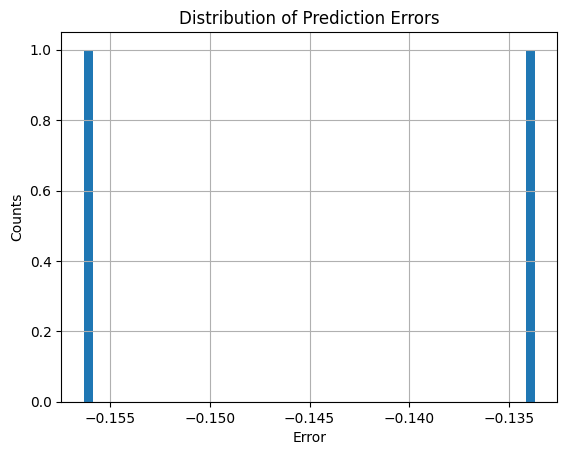


Importance of each feature used in the model:
SOR_rank: 0.3912081779105097
FPI_rank: 0.22565967749454827
pctJuniors: 0.03170728970095254
pctSeniors: 0.03013164790244492
numSeniors: 0.023698986185198164
numFreshmen: 0.02269237534628409
numOffense: 0.021236356340192112
pctFreshmen: 0.021131544009232738
numQB: 0.020432646060380158
numDL: 0.01806466672592587
numC: 0.015808376782285624
SOS_rank: 0.015210650982692187
numJuniors: 0.014743412713089257
numPlayers: 0.01234241567566325
class_score: 0.01067017074523103
numSophomores: 0.010530173890334745
numOL: 0.009140058485105889
numPositions: 0.008550059764898432
numWR: 0.008419795697552345
pctSophomores: 0.008209631662314022
numDB: 0.007124487655415774
numOT: 0.006657198969232703
numK: 0.006566650639127908
numRB: 0.006348065226740606
class_confRank: 0.006344676606330826
class_natlRank: 0.005742591017251526
numLS: 0.0056887734704575855
numLB: 0.0055051145589590815
numDefense: 0.005496902610039366
numTE: 0.004542849123138007
numS: 0.00423246836

In [16]:
# Create a Random Forest Classifier
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(bootstrap=True, n_estimators=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

results = y_pred - y_test
unique, counts = np.unique(results, return_counts=True)

# Plot residuals
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1, 1, 1)
ax.hist(results, bins=50)
ax.set(xlabel='Error', ylabel='Counts',
       title='Distribution of Prediction Errors')
ax.grid(True)
plt.show()

# Feature Importances
print("\nImportance of each feature used in the model:")
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
for idx in sorted_indices:
    print(f"{X.columns[idx]}: {feature_importances[idx]}")

# Correlation matrix of the dataframe
print("\n\nCorrelation matrix of the dataframe, showing the Pearson correlation coefficients between each pair of features:")
correlation_matrix = refined_data.corr()
target_correlation = correlation_matrix['overallPct'].abs().sort_values(ascending=False)
print(target_correlation)

# Features ranked via RFE
from sklearn.feature_selection import RFE
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X.columns))
print("\n\nFeatures ranked via RFE:")
print(ranked_features)

# Features ranked via ANOVA F-value
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), selector.scores_), X.columns))
print("\n\nFeatures ranked via ANOVA F-value:")
print(ranked_features)